In this project, I will conduct a series of tasks on our site traffic dataset to develop a predictive model that determines whether a recipe leads to high traffic. I will utilize machine learning models for this prediction task and will report the performance of these models based on unseen test data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

In [2]:
df = pd.read_csv("recipe_site_traffic_2212.csv")
print(df.shape)
df.head(10)

(947, 8)


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
6,7,183.94,47.95,9.75,46.71,Chicken Breast,4,NaN
7,8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,NaN
8,9,538.52,3.78,3.37,3.79,Pork,6,High
9,10,248.28,48.54,3.99,113.85,Chicken,2,NaN


# Data Validation
Before anything, we must validate the data.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


Some type conversion are needed.

In [4]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


No negative values in subingredients.

In [5]:
df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

The null values in high_traffic represent False. Null values in calories, carbohydrate, sugar, protein need to be filled.

**IT'S IMPORTANT THAT WE SHOULD NOT REPLACE NULL VALUES BASED ON THE METRICS OF ENTIRE DATASET**
**We want to test our data on truly unseen data, so we should not leak the metrics (such as mean, median, mode) of entire data set to our test data.**
This is How things should be done to avoid data leak.

**Scaling and Null values replacement should be done based on the metrics of train data, not entire data set. This is to avoid data leakage**

That's why I'll address this problem right before training my model.


In [6]:
df['high_traffic'] = df['high_traffic'].fillna(False)
df['high_traffic'] = df['high_traffic'].replace('High', True)
df['high_traffic'] = df['high_traffic'].astype(bool)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  947 non-null    bool   
dtypes: bool(1), float64(4), int64(1), object(2)
memory usage: 52.8+ KB
None


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,True
1,2,35.48,38.56,0.66,0.92,Potato,4,True
2,3,914.28,42.68,3.09,2.88,Breakfast,1,False
3,4,97.03,30.56,38.63,0.02,Beverages,4,True
4,5,27.05,1.85,0.80,0.53,Beverages,4,False


In [7]:
print(df['category'].unique())
print(df['servings'].unique())

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
['6' '4' '1' '2' '4 as a snack' '6 as a snack']


Chicken Breast is the same thing is Chicken. also, '4 as a snack' and '6 as a snack' will be replace by 4, 6.

In [8]:
df['servings'] = df['servings'].replace('4 as a snack', 4)
df['servings'] = df['servings'].replace('6 as a snack', 6)
df['category'] = df['category'].replace('Chicken Breast', 'Chicken')
df['servings'] = df['servings'].astype(int)
df['category'] = df['category'].astype('category')
print(df['category'].unique())
print(df['servings'].unique())
print(df.info())
df.head()

['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert']
Categories (10, object): ['Beverages', 'Breakfast', 'Chicken', 'Dessert', ..., 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']
[6 4 1 2]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        947 non-null    int64   
 1   calories      895 non-null    float64 
 2   carbohydrate  895 non-null    float64 
 3   sugar         895 non-null    float64 
 4   protein       895 non-null    float64 
 5   category      947 non-null    category
 6   servings      947 non-null    int64   
 7   high_traffic  947 non-null    bool    
dtypes: bool(1), category(1), float64(4), int64(2)
memory usage: 46.7 KB
None


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,True
1,2,35.48,38.56,0.66,0.92,Potato,4,True
2,3,914.28,42.68,3.09,2.88,Breakfast,1,False
3,4,97.03,30.56,38.63,0.02,Beverages,4,True
4,5,27.05,1.85,0.80,0.53,Beverages,4,False


In [9]:
df['recipe'].duplicated().sum()

0

no duplicated values in index column which is good.

In [10]:
# df = df.set_index("recipe")
print(df.shape)
df.head()

(947, 8)


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,True
1,2,35.48,38.56,0.66,0.92,Potato,4,True
2,3,914.28,42.68,3.09,2.88,Breakfast,1,False
3,4,97.03,30.56,38.63,0.02,Beverages,4,True
4,5,27.05,1.85,0.80,0.53,Beverages,4,False


As a summary, this is the work I undertook for each column:

- recipe: Ensured that there are no duplicates and set it as index.
- calories: Checked for negative values and will fill Null Values.
- carbohydrate: Checked for negative values and will fill Null Values.
- sugar: Checked for negative values and will fill Null Values.
- protein: Checked for negative values and will fill Null Values.
- category: Replaced 'Chicken Breast' with 'Chicken' and converted the column to category type.
- servings: converted "4 as a snack" and "6 as a snack" to 4 and 6 respectively; converted column to numeric values.
- protein: Checked for negative values and filled Null Values.
- high_traffic: Replaced "High" and NaN with True and False respectively, thus converting the column to boolean.

# Exploratory Data Analysis
The main goal of Exploratory Data Analysis (EDA) is to understand the underlying patterns, relationships, and structures within a dataset before applying more formal statistical analyses or machine learning models.

<Figure size 1200x600 with 0 Axes>

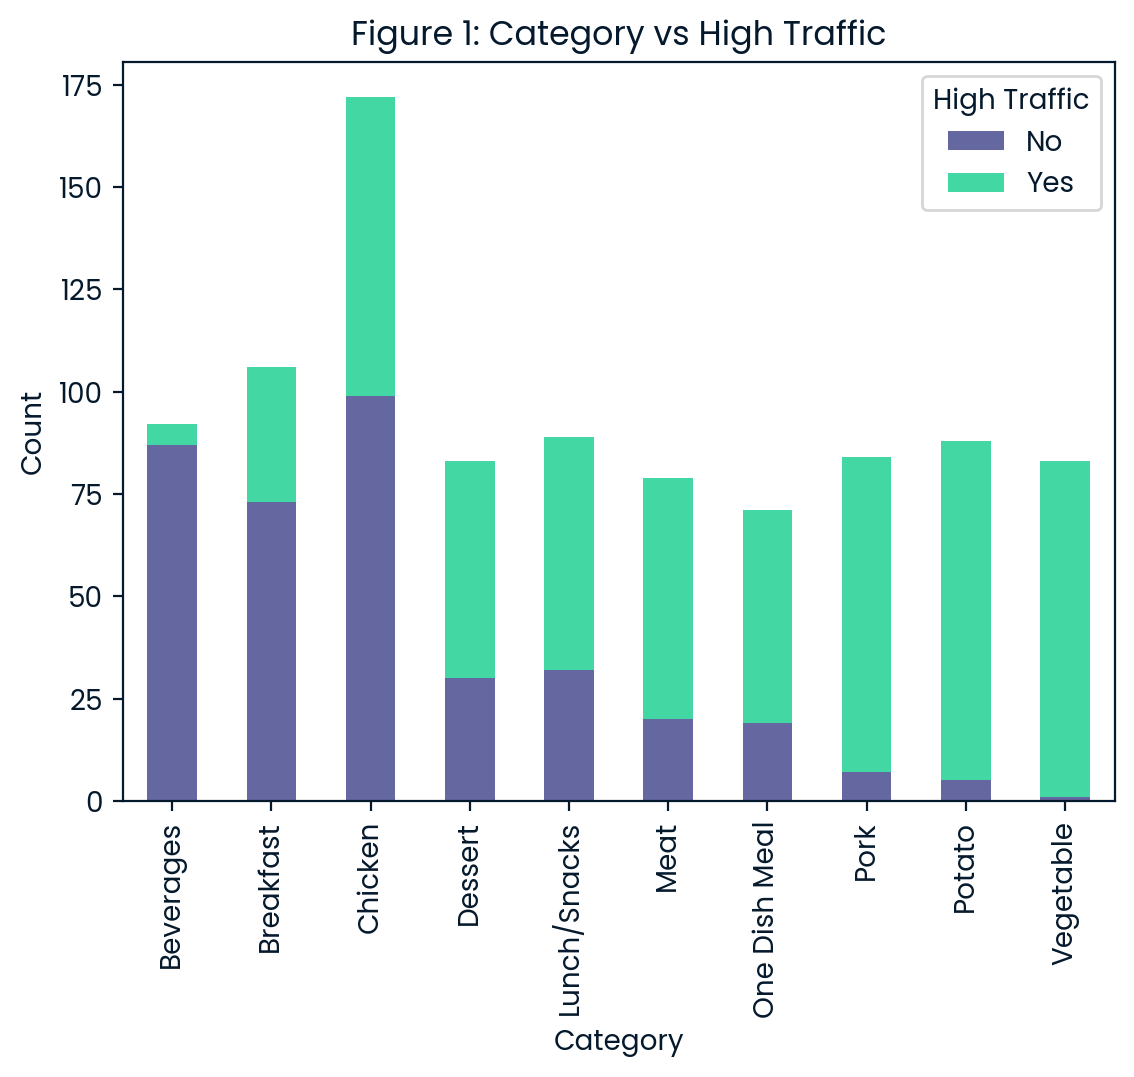

In [11]:
plt.figure(figsize=(12, 6))
count_data = df.groupby(['category', 'high_traffic']).size().unstack(fill_value=0)
count_data.plot(kind='bar', stacked=True)
plt.title('Figure 1: Category vs High Traffic')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='High Traffic', labels=['No', 'Yes'])
plt.show()

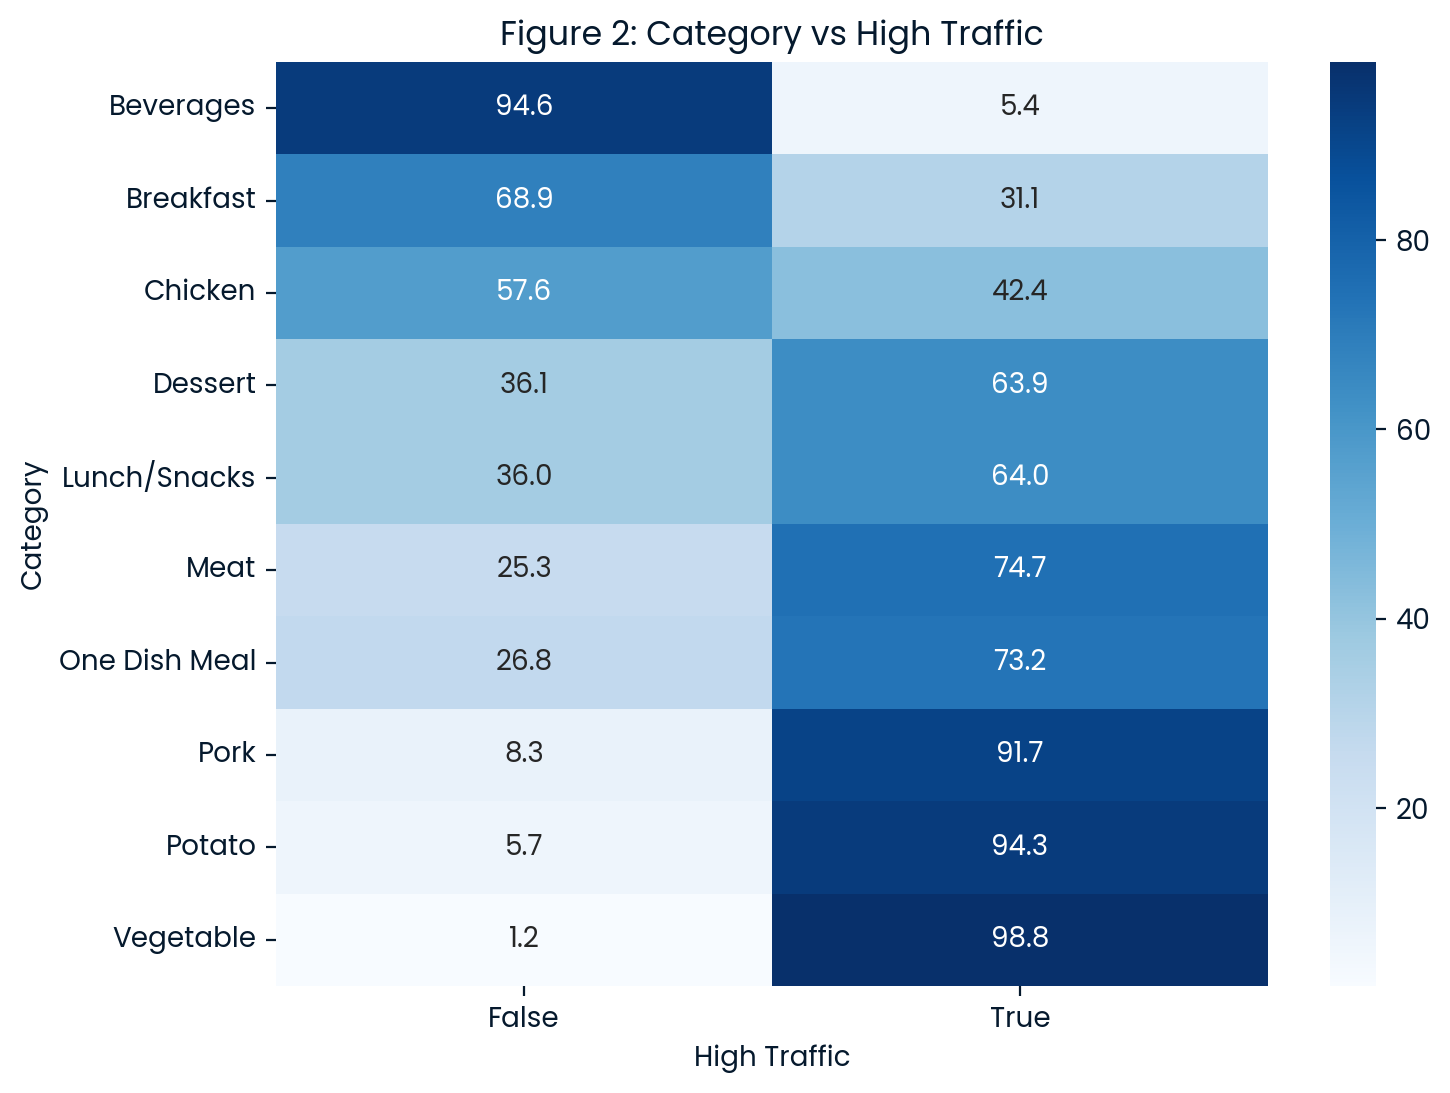

In [12]:
contingency_table = pd.crosstab(df['category'], df['high_traffic'])
percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(percentages, annot=True, fmt='.1f', cmap='Blues')
plt.title("Figure 2: Category vs High Traffic")
plt.xlabel("High Traffic")
plt.ylabel("Category")
plt.show()

The two figures above indicate that the category is well effective on traffic site. as some categories like vegtable, potato, pork, meat, one dish meal, are more likely to result in high traffic. As oppose to Bevarages and Breakfast which result in low traffic in most cases. 

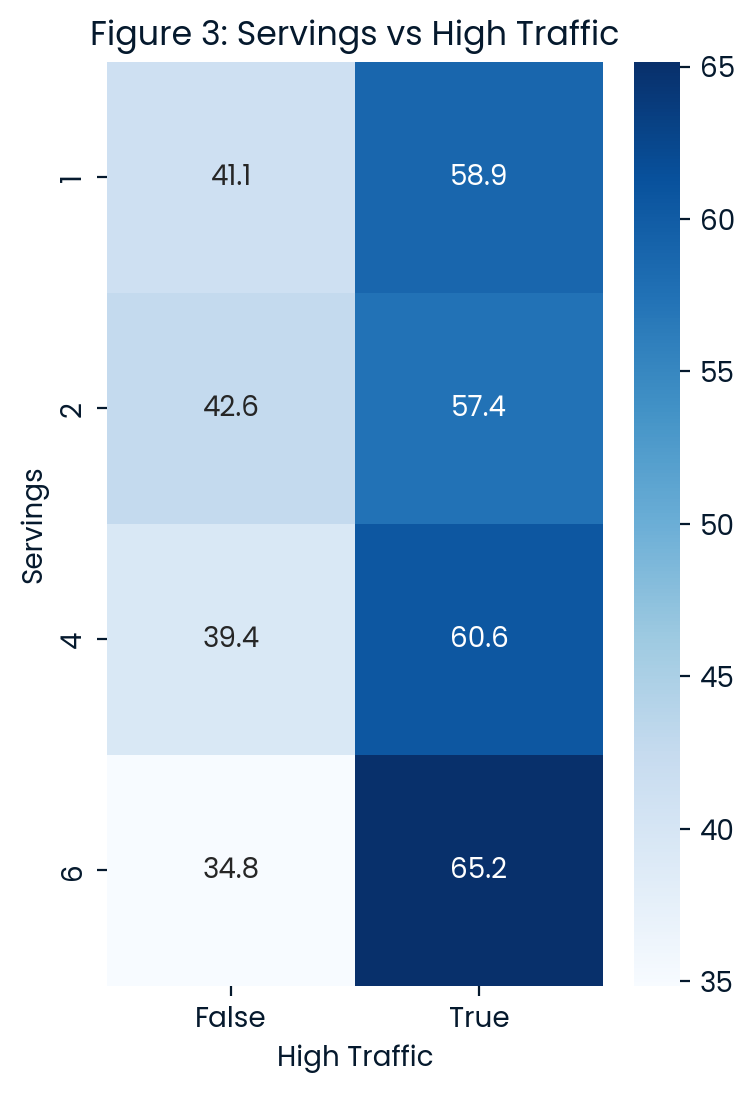

In [13]:
contingency_table = pd.crosstab(df['servings'], df['high_traffic'])
percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

plt.figure(figsize=(4, 6))
sns.heatmap(percentages, annot=True, fmt='.1f', cmap='Blues')
plt.title("Figure 3: Servings vs High Traffic")
plt.xlabel("High Traffic")
plt.ylabel("Servings")
plt.show()

This figure indicates that the servings number are not so effective on traffic site and are not correlated with site's traffic by themselves. As traffic is almost equally distributed in each servings count.

Text(0.5, 1.0, 'Figure 4: Percentage of High Traffic Recipes by Servings and Category')

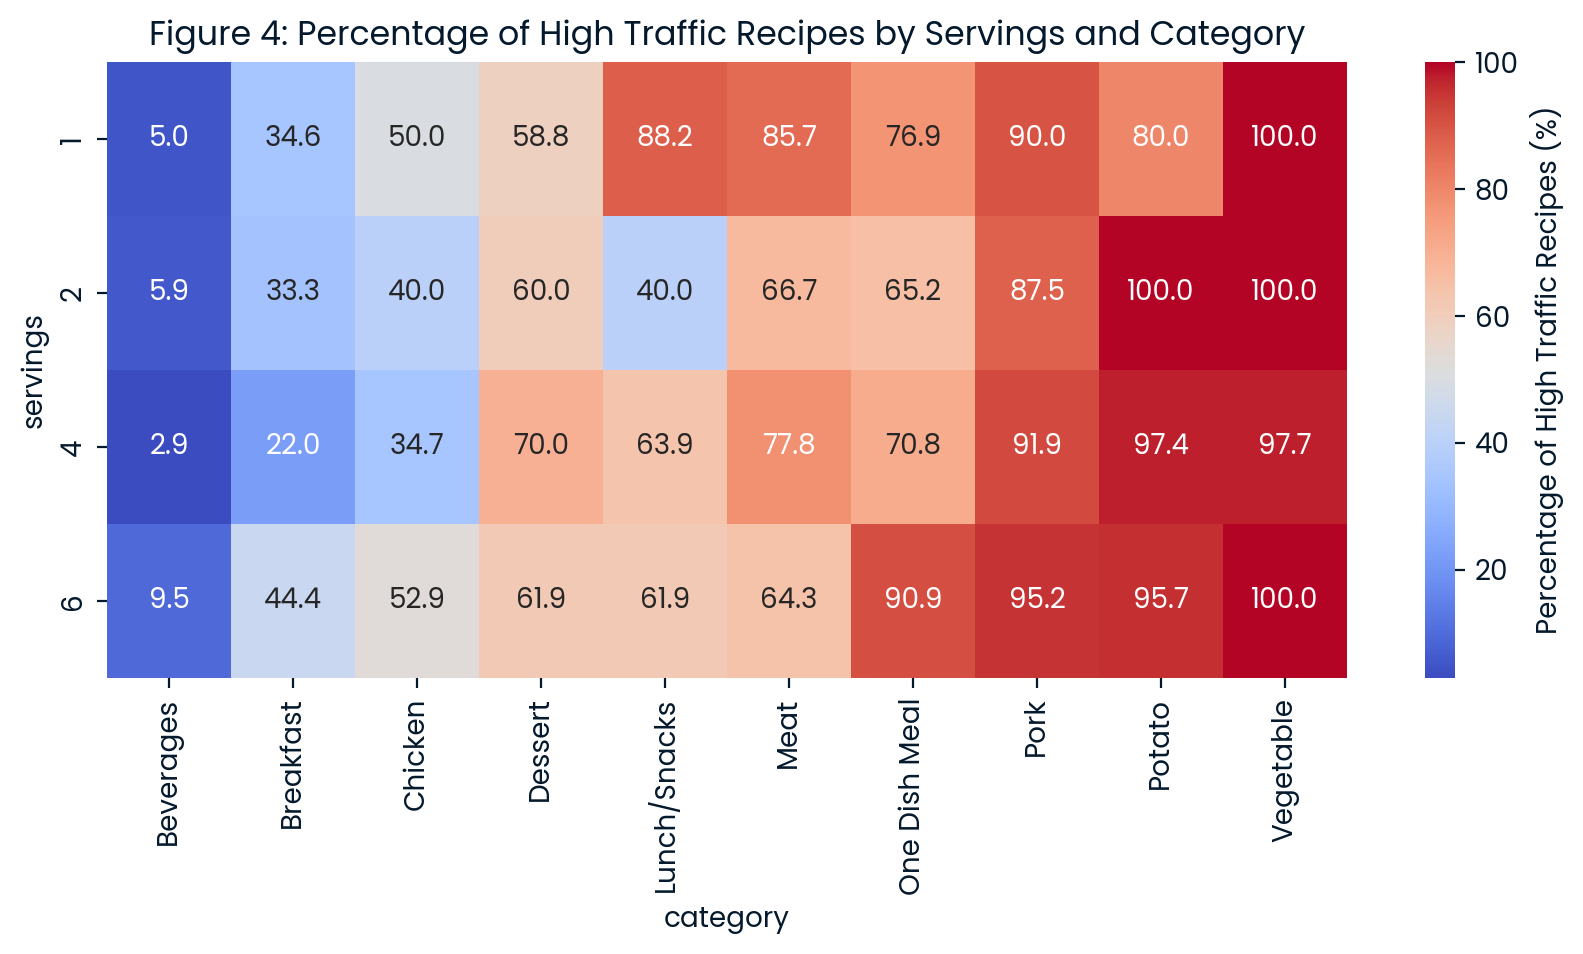

In [14]:
grouped_df = df.groupby(["servings", "category"])["high_traffic"].mean()*100
heatmap_data = grouped_df.unstack()
fig = plt.figure(figsize=(10, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "Percentage of High Traffic Recipes (%)"})
plt.title("Figure 4: Percentage of High Traffic Recipes by Servings and Category")

This figure indicates that the servings number and cateogry might be effective on traffic site alongside each other.

Text(0.5, 0.98, 'Figure 5: Correlation Heatmaps by Category')

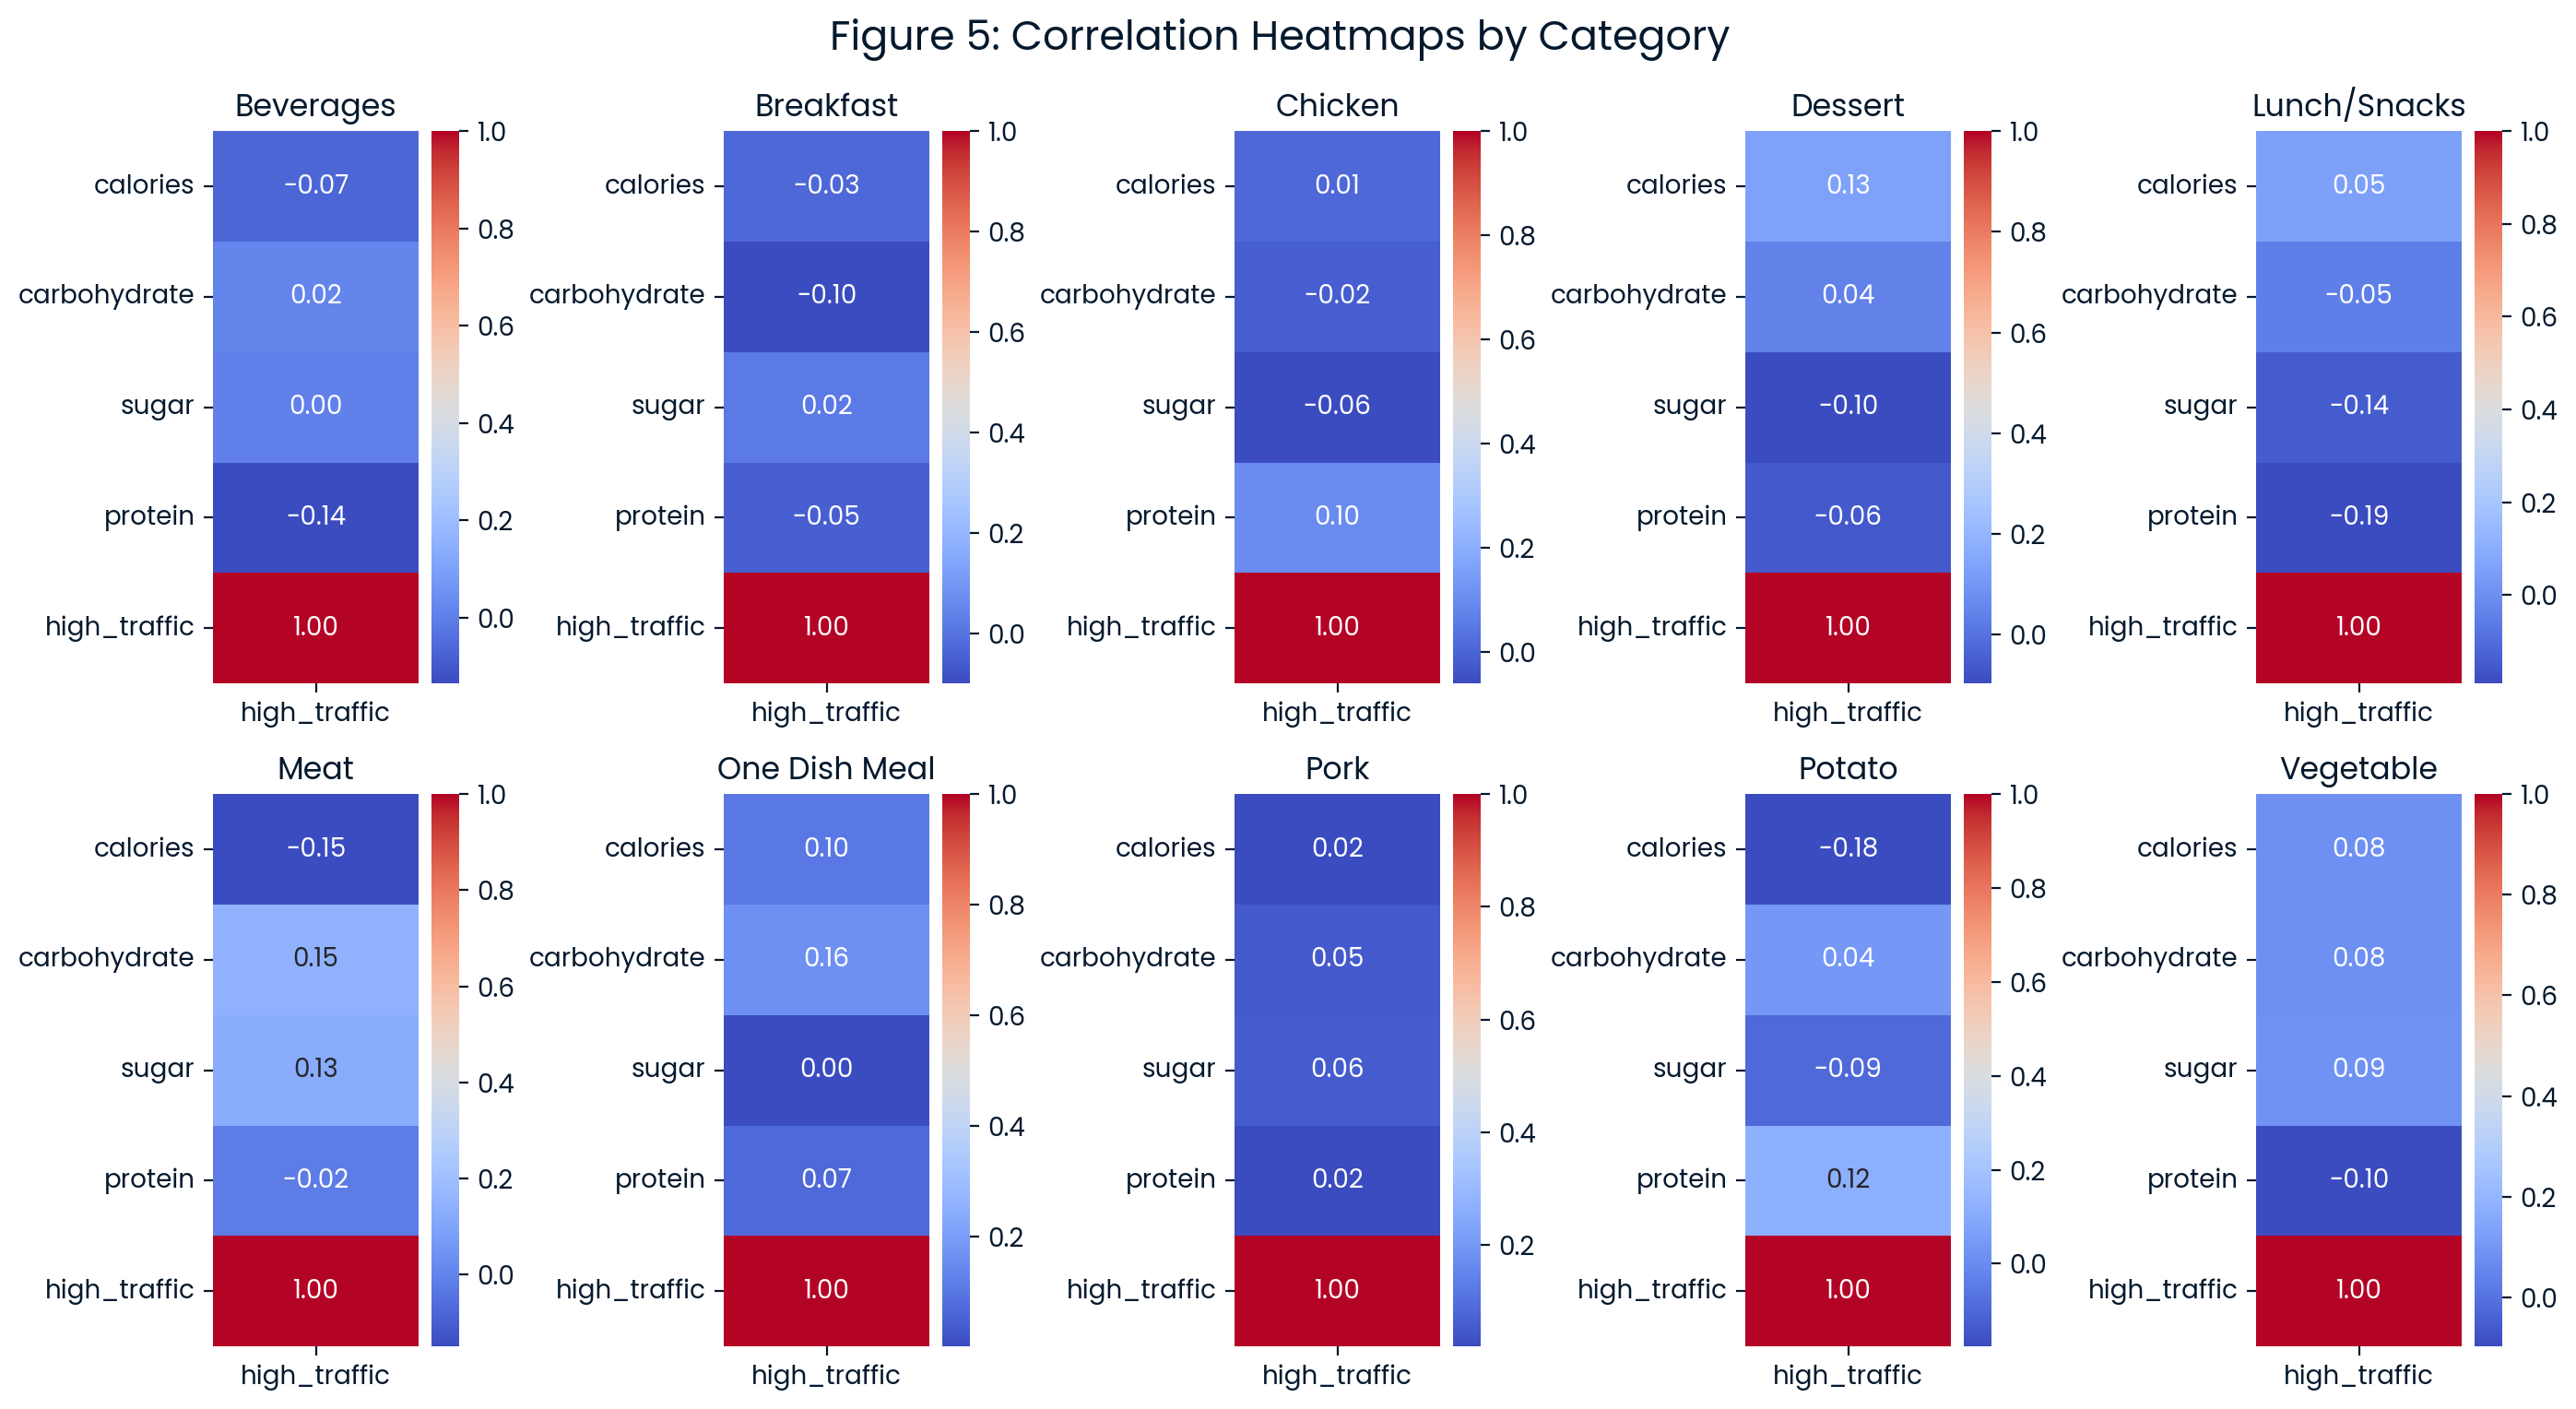

In [15]:
grouped = df.groupby('category')


# Set up the grid for subplots
num_categories = len(grouped)
cols = 5  # Number of columns in the grid
rows = (num_categories + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Create heatmaps for each group
for ax, (name, group) in zip(axes, grouped):
    # Calculate correlation matrix
    corr = group[["calories", "carbohydrate", "sugar", "protein", "high_traffic"]].corr()
    
    # Create a heatmap
    sns.heatmap(corr[['high_traffic']], annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title(f'{name}')
    
# Hide any unused subplots
for i in range(num_categories, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
fig.suptitle('Figure 5: Correlation Heatmaps by Category', fontsize=16)

Text(0.5, 0.98, 'Figure 6: Correlation Heatmaps by Servings')

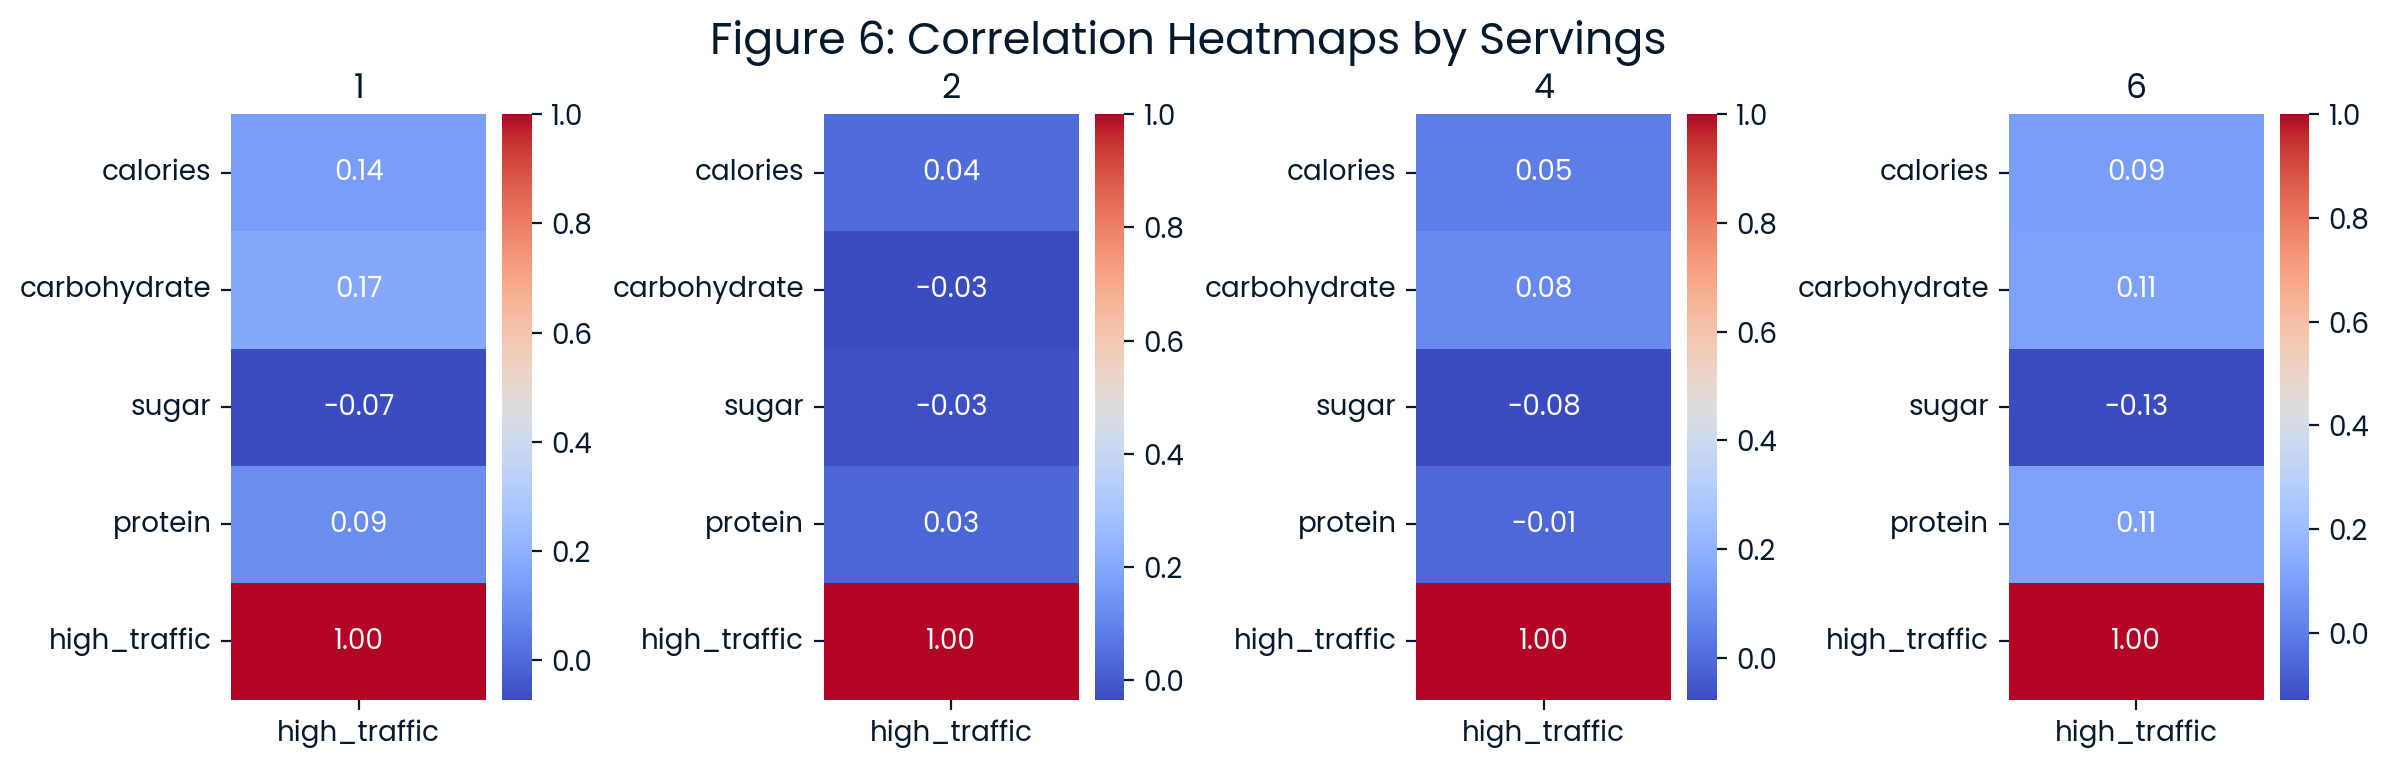

In [16]:
grouped = df.groupby('servings')


# Set up the grid for subplots
num_categories = len(grouped)
cols = 4  # Number of columns in the grid
rows = (num_categories + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Create heatmaps for each group
for ax, (name, group) in zip(axes, grouped):
    # Calculate correlation matrix
    corr = group[["calories", "carbohydrate", "sugar", "protein", "high_traffic"]].corr()
    
    # Create a heatmap
    sns.heatmap(corr[['high_traffic']], annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title(f'{name}')
    
# Hide any unused subplots
for i in range(num_categories, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
fig.suptitle('Figure 6: Correlation Heatmaps by Servings', fontsize=16)

These figues indicate that the calories, carbs, sugar, protein are not so effective on traffic site, as they are not correlated with site's traffic solely, even when catagorized by servings or category.

## Summary of EDA
Category is the most important and affective features based on Figure 1 and 2. Although Servings is not effecitve by itself based on Figure 4, when visualized alongside Category, some correlation can be seen which should be confirmed by the machine learning model. 

Figure 4 shows which categories accrue the most traffic for the website based on the number of servings. The interesting results lie cases that do not conform to the rest of the serving sizes. For instance, Lunch/Snacks performs very highly for a serving size of 1 (Percent high traffic = 88.2%), but does not do as well for other serving sizes. One dish meals score highly for serving sizes of 6 but not on other serving sizes.

Figure 5 and indicate that the ingredients have almost no affect on wether the size has high traffic or not, even when catagorized by servings or category.

# Model Developement
I've decided to use Logistic Regression, KNN Since this is a classification task. I'll compare the results and deploy the best model based on performence. I will be using cross validation using GridSearchCV to find the best paramaters for our model. This is the process:

1. Features and Labels Separation:  Predictor variables are assigned to a variable X whereas the target variable "high_traffic" is assigned to a variable y.
2. Train/Test: The dataset is fractioned into a training and validation set.

Then, for each Round of CV, this process should be followed:
1. Filling Nulls: Replacing each null value with the mean value of each column grouped by category.
2. Scaling: I'll use standard scaler to scale my data as it is necessary for algorithms such as KNN.
3. One-Hot Coding: Category column need to be converted to one-hot format.
4. Train: training the model.

**Scaling and Null values replacement should be done based on the metrics of train data, not entire data set. This is to avoid data leakage. We need to create a pipeline to automate the process.**

In [17]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,True
1,2,35.48,38.56,0.66,0.92,Potato,4,True
2,3,914.28,42.68,3.09,2.88,Breakfast,1,False
3,4,97.03,30.56,38.63,0.02,Beverages,4,True
4,5,27.05,1.85,0.80,0.53,Beverages,4,False


In [18]:
Y = df['high_traffic']
X = df.drop(['high_traffic', 'recipe'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 101) # Keeping 0.2 as test

In [19]:
X_train.groupby('category').agg('mean')

,calories,carbohydrate,sugar,protein,servings
category,,,,,
Beverages,177.400986,16.017324,12.217606,0.601690,3.183099
Breakfast,330.462125,37.058250,7.145500,17.004250,3.012500
Chicken,567.263256,23.979767,5.394264,48.034341,3.376812
Dessert,366.351475,56.049016,35.371148,6.030000,3.569231
Lunch/Snacks,460.947742,49.620645,4.345806,20.511774,3.441176
Meat,610.646000,23.314462,5.699538,38.319231,3.471429
One Dish Meal,591.524286,46.174821,4.553750,36.070357,3.050000
Pork,584.921129,30.165968,8.534516,42.353871,3.830986
Potato,428.543788,57.638182,3.862273,8.701818,3.842857


In [20]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col, strategy='mean'):
        self.group_col = group_col
        self.strategy = strategy
        self.fill_values_ = None

    def fit(self, X, y=None):
        # Calculate fill values based on the specified strategy
        if self.strategy == 'mean':
            self.fill_values_ = round(X.groupby(self.group_col).mean(),2)
        elif self.strategy == 'median':
            self.fill_values_ = round(X.groupby(self.group_col).median(),2)
        elif self.strategy == 'mode':
            self.fill_values_ = round(X.groupby(self.group_col).agg(lambda x: x.value_counts().index[0]),2)
        else:
            raise ValueError("Invalid strategy. Choose from 'mean', 'median', or 'mode'.")

        return self

    def transform(self, X):
        if self.fill_values_ is None:
            raise ValueError("The fit method must be called before transform.")

        # Create a copy of the DataFrame to avoid modifying the original
        X_filled = X.copy()

        # Iterate over each group and fill NaNs with the calculated fill values
        for name, group in X_filled.groupby(self.group_col):
            if name in self.fill_values_.index:
                fill_values = self.fill_values_.loc[name]
                # Fill NaN values in the original DataFrame with the calculated fill values
                X_filled.loc[group.index] = group.fillna(fill_values)

        return X_filled

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)


This is how our data looks like after imputing nulls using mean by default and one hot encoding, before scaling:

In [21]:
categorical_columns = ['category']
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False), categorical_columns)
    ],
    remainder='passthrough'  # Keeps numeric columns as they are
)
sample_pipe = Pipeline(steps=[('imputer', CustomImputer(group_col='category')),('preprocessor', preprocessor)])

sample_pipe.fit(X_train, y_train)
# Transform X_train using the pipeline up to the last step (KNN), so we only see the preprocessed data
X_train_transformed = sample_pipe.transform(X_train)

# Optionally, convert to DataFrame for a clearer look if the columns have names
if hasattr(sample_pipe.named_steps['preprocessor'], 'get_feature_names_out'):
    transformed_columns = sample_pipe.named_steps['preprocessor'].get_feature_names_out()
    X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_columns)
else:
    X_train_transformed_df = pd.DataFrame(X_train_transformed)

X_train_transformed_df

,onehot__category_Beverages,onehot__category_Breakfast,onehot__category_Chicken,onehot__category_Dessert,onehot__category_Lunch/Snacks,onehot__category_Meat,onehot__category_One Dish Meal,onehot__category_Pork,onehot__category_Potato,onehot__category_Vegetable,remainder__calories,remainder__carbohydrate,remainder__sugar,remainder__protein,remainder__servings
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.86,17.28,10.33,60.57,4.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.42,8.11,0.37,0.36,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,584.92,30.17,8.53,42.35,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,249.33,69.42,7.91,11.29,4.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,879.61,0.03,8.34,7.83,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,128.30,210.77,112.24,13.02,4.0
753,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,727.55,2.81,1.01,28.55,4.0
754,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,138.11,3.70,5.24,63.56,4.0
755,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.78,2.97,7.55,0.70,6.0


In [22]:
pipe = Pipeline(steps=[('imputer', CustomImputer(group_col='category')),('preprocessor', preprocessor), ('scaler', StandardScaler()), ('knn', KNN())])
param_grid = {
    'knn__n_neighbors': list(range(5, 41, 5)),  # Range of neighbors
    'knn__weights': ['uniform', 'distance'],  # Weights
    'knn__leaf_size': [10, 20, 30, 40],  # Leaf size for tree-based algorithms
}
knn_cv_classifier = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
knn_cv_classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        CustomImputer(group_col='category')),
                                       ('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['category'])])),
                                       ('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__leaf_size': [10, 20, 30, 40],
                         'knn__n_neighbors': [5, 10, 15, 20, 25, 30, 35, 40],
                         'knn__weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [23]:
results = knn_cv_classifier.cv_results_
results_df = pd.DataFrame(results)
print("Best Score:", knn_cv_classifier.best_score_)
print("Best Score:", knn_cv_classifier.best_params_)
results_df[['params', 'mean_test_score', 'std_test_score']]

Best Score: 0.8113985031814328
Best Score: {'knn__leaf_size': 10, 'knn__n_neighbors': 40, 'knn__weights': 'uniform'}


,params,mean_test_score,std_test_score
0,"{'knn__leaf_size': 10, 'knn__n_neighbors': 5, ...",0.746633,0.032899
1,"{'knn__leaf_size': 10, 'knn__n_neighbors': 5, ...",0.749259,0.035007
2,"{'knn__leaf_size': 10, 'knn__n_neighbors': 10,...",0.778433,0.038399
3,"{'knn__leaf_size': 10, 'knn__n_neighbors': 10,...",0.776672,0.039190
4,"{'knn__leaf_size': 10, 'knn__n_neighbors': 15,...",0.791865,0.043427
...,...,...,...
59,"{'knn__leaf_size': 40, 'knn__n_neighbors': 30,...",0.801200,0.038666
60,"{'knn__leaf_size': 40, 'knn__n_neighbors': 35,...",0.809439,0.039315
61,"{'knn__leaf_size': 40, 'knn__n_neighbors': 35,...",0.802537,0.037873
62,"{'knn__leaf_size': 40, 'knn__n_neighbors': 40,...",0.810992,0.041569


In [24]:
pipe = Pipeline(steps=[('imputer', CustomImputer(group_col='category')),('preprocessor', preprocessor), ('scaler', StandardScaler()), ('lr', LR())])
param_grid = {
    'lr__C': [0.01, 0.1, 0.2, 0.5, 1, 10, 100],  # Regularization strength
    'lr__penalty': ['l2'],  # Penalty
    'lr__max_iter': [50, 100, 200, 300],  # Maximum iterations
    
}
lr_cv_classifier = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
lr_cv_classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        CustomImputer(group_col='category')),
                                       ('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['category'])])),
                                       ('scaler', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.01, 0.1, 0.2, 0.5, 1, 10, 100],
                         'lr__max_iter': [50, 100, 200, 300],
                         'lr__penalty': ['l2']},
             scoring='roc_auc')

In [25]:
results = lr_cv_classifier.cv_results_
results_df = pd.DataFrame(results)
print("Best Score:", lr_cv_classifier.best_score_)
print("Best Score:", lr_cv_classifier.best_params_)
results_df[['params', 'mean_test_score', 'std_test_score']]

Best Score: 0.8162914715414299
Best Score: {'lr__C': 0.01, 'lr__max_iter': 50, 'lr__penalty': 'l2'}


,params,mean_test_score,std_test_score
0,"{'lr__C': 0.01, 'lr__max_iter': 50, 'lr__penal...",0.816291,0.049433
1,"{'lr__C': 0.01, 'lr__max_iter': 100, 'lr__pena...",0.816291,0.049433
2,"{'lr__C': 0.01, 'lr__max_iter': 200, 'lr__pena...",0.816291,0.049433
3,"{'lr__C': 0.01, 'lr__max_iter': 300, 'lr__pena...",0.816291,0.049433
4,"{'lr__C': 0.1, 'lr__max_iter': 50, 'lr__penalt...",0.812278,0.049573
5,"{'lr__C': 0.1, 'lr__max_iter': 100, 'lr__penal...",0.812278,0.049573
6,"{'lr__C': 0.1, 'lr__max_iter': 200, 'lr__penal...",0.812278,0.049573
7,"{'lr__C': 0.1, 'lr__max_iter': 300, 'lr__penal...",0.812278,0.049573
8,"{'lr__C': 0.2, 'lr__max_iter': 50, 'lr__penalt...",0.811767,0.049691
9,"{'lr__C': 0.2, 'lr__max_iter': 100, 'lr__penal...",0.811767,0.049691


Text(0, 0.5, 'Feature')

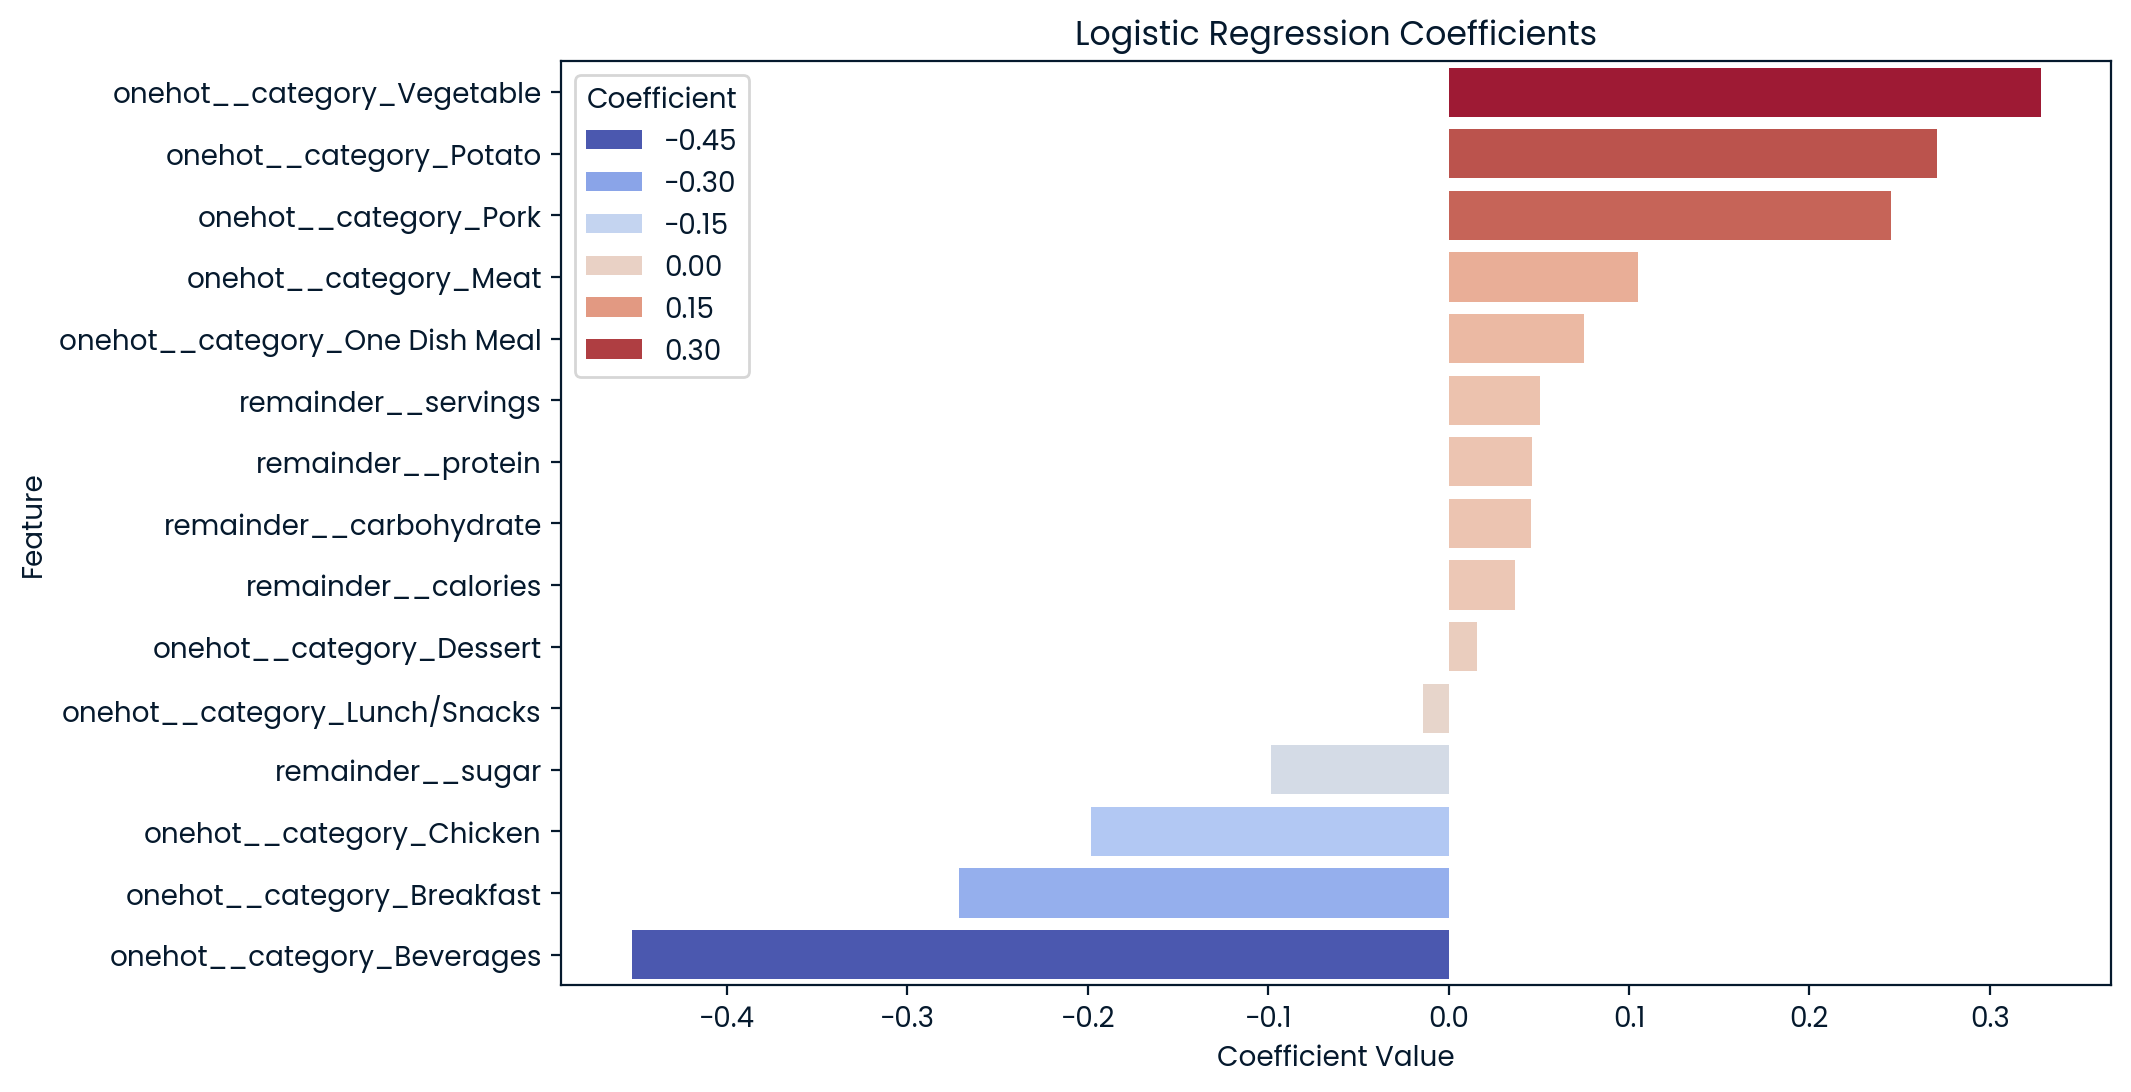

In [30]:
model = lr_cv_classifier.best_estimator_

# Access the logistic regression model from the pipeline
log_reg_model = model.named_steps['lr'] 

log_coef = pd.DataFrame(log_reg_model.coef_.flatten(), columns=['Coefficient'], index=X_train_transformed_df.columns)


log_coef_sorted = log_coef.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y=log_coef_sorted.index, x=log_coef_sorted['Coefficient'], orient='h', palette='coolwarm', hue = log_coef_sorted['Coefficient'])
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')


In K-Nearest Neighbors (KNN), unlike some other algorithms like decision trees or linear regression, there is no inherent feature importance score because KNN is a non-parametric algorithm that does not build a model in the traditional sense. 

Altough we found out KNN has performed better, we can use the coefficients of features in Logistic Regresion Model to find out which features are most important.  As exepected, categorial columns resulted in much higher coeficients. Just as we predicted, Beverages and Breakfasts are less likely to result in high traffic while Vegetable, Potato, Pork, Meat and One Dish are more likely to result in high traffic. It's also important to note that ingredients are considered as less important features, we'll discuss this further in Buisness Metrics.

We stll need to evaluate our model on truely unseen data to make a final decision.

# Model Evaluation
Now that we've adjusted hyper parameters with GridSearch, we need to report a final performance evaluation. let's compare the performance of both models.

confusion matrix for KNN

In [26]:
knn_y_predict = knn_cv_classifier.predict(X_test)

pd.DataFrame(classification_report(y_test, knn_y_predict, output_dict=True)).transpose()

,precision,recall,f1-score,support
False,0.762500,0.792208,0.777070,77.000000
True,0.854545,0.831858,0.843049,113.000000
accuracy,0.815789,0.815789,0.815789,0.815789
macro avg,0.808523,0.812033,0.810060,190.000000
weighted avg,0.817243,0.815789,0.816310,190.000000


confusion matrix for Logistic Regression

In [27]:
lr_y_predict = lr_cv_classifier.predict(X_test)
pd.DataFrame(classification_report(y_test, lr_y_predict, output_dict=True)).transpose()

,precision,recall,f1-score,support
False,0.750000,0.545455,0.631579,77.000000
True,0.738806,0.876106,0.801619,113.000000
accuracy,0.742105,0.742105,0.742105,0.742105
macro avg,0.744403,0.710780,0.716599,190.000000
weighted avg,0.743342,0.742105,0.732708,190.000000


They perform almost equally. However, KNN seems a little more proper since it resulted in 0.77 and 0.84 F1_score for False and True predictions.
Let's explore KNN further and compare it with Logistic:

In [28]:
print(f'ROC for rf is {roc_auc_score(y_test, lr_y_predict)}')
print(f'ROC for KNN is {roc_auc_score(y_test, knn_y_predict)}')

ROC for rf is 0.7107803700724055
ROC for KNN is 0.8120330996437191


KNN is better. Roc Curve for KNN:

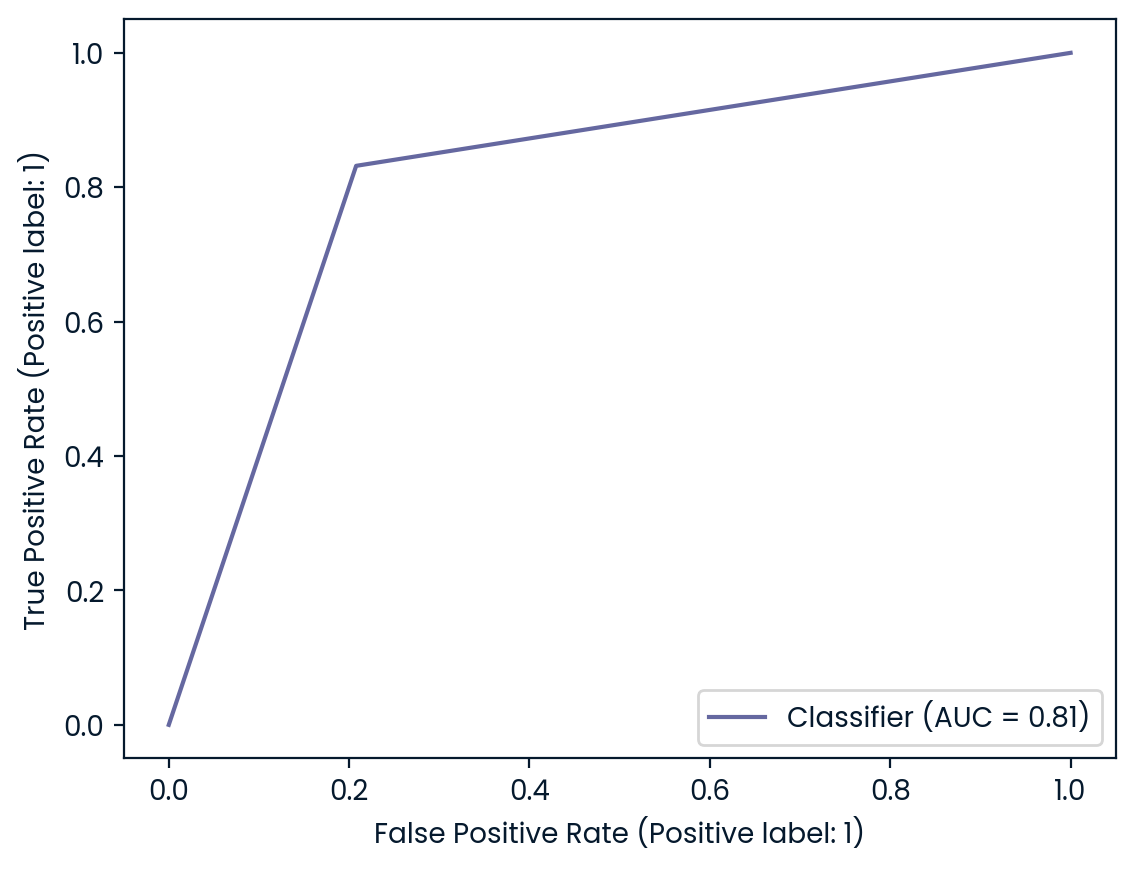

In [29]:
RocCurveDisplay.from_predictions(y_test, knn_y_predict)

# Business Metrics


In [31]:
pd.DataFrame(classification_report(y_test, knn_y_predict, output_dict=True)).transpose()

,precision,recall,f1-score,support
False,0.762500,0.792208,0.777070,77.000000
True,0.854545,0.831858,0.843049,113.000000
accuracy,0.815789,0.815789,0.815789,0.815789
macro avg,0.808523,0.812033,0.810060,190.000000
weighted avg,0.817243,0.815789,0.816310,190.000000


The model performs better in predicting the True class than the False class, as indicated by the higher precision and recall scores for True.

There is some imbalance in performance between the two classes, suggesting that further model tuning or the use of techniques like class weighting or oversampling the minority class could improve overall predictive performance.

The model has a reasonable overall accuracy of 81%, but you may want to explore strategies to enhance the identification of the False class to reduce misclassifications.

To improve overall accuracy, we could consider preparing a larger dataset, which would provide more diverse examples for the model to learn from. Additionally, utilizing more sophisticated machine learning models, such as neural networks, may enhance our predictions.

# Final summary including recommendations that the business should undertake

Here is a quick summary of the work I undertook

**Data Validation:** As part of my work, I first validated the data to prepare our dataset for further analysis and model training. This involved ensuring there were no duplicates in the index and checking for negative values in the sub-ingredient columns. I replaced "chicken breast" with "chicken" in the category column and corrected the servings column by converting "4 added snack" and "6 as a snack" to "4" and "6," respectively. Additionally, I modified the high traffic column by replacing "high" and null values with "true" and "false," converting the column to a Boolean format. I also managed null values in model developement.

**EDA:** Next, I explored the data using appropriate charts and plots to gain insights into potential predictions and to identify important features for further evaluation.

**Model Developement:** I then developed a prediction model to determine whether a recipe would generate high traffic. I chose the parameters of my model by cross-validating different hyperparameters. To accomplish this, I utilized Grid Search CV, which systematically explored all the hyperparameters I provided as input. This process enabled me to identify the optimal hyperparameters that resulted in the highest ROC accuracy.

Altough we found out KNN has performed better, it gives us a good insight of our feature importance by taking a look at the feature importances in Logistic Regression. It was revealed that the most important features identified by the model were the categorical columns, while sub-ingredients provided little informative value regarding high traffic outcomes, as I had expected during the exploratory data analysis (EDA).

I used a pipeline object to automate the processes of imputing, one-hot encoding, and scaling for each set of cross-validation. It is crucial that we avoid imputing null values at the beginning of exploration, as no metrics from the test data should leak into our training data. Therefore, we should not scale or fill null values using metrics such as the mean, median, minimum, or maximum of the entire dataset, which includes the test data. This practice ensures accurate evaluations on truly unseen data and maintains the integrity of our model's performance assessment.

**Model Evaluation:** Lastly, I evaluated the model by making predictions on the test data and reporting its performance as the final assessment. This evaluation marks the conclusion of the model training process, and I will not conduct any further training on this model. Based on the F1 score for true and false predictions, I concluded that a KNN model was the most effective choice. 

**Recomindations for Business:** Given these findings, I recommend that for future predictions, we focus on tracking only the category of a recipe, as it is the most significant and effective feature for our model to train on. Training the model on less important data only complicates and slows the training process and does not add much performance to our model, let alone it might add some noise.
